# Load Data & import libraries

In [1]:
import helperfunction as hf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.precision', 3)

# process tn.movie_budgets.csv data set for budget, and revenues

In [2]:
# focus on tn.movie budget first
file = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/tn.movie_budgets.csv.gz'
budget = pd.read_csv(file, parse_dates=['release_date'])
# we don't need id coloumn
hf.drop_columns(budget, 'id')
# remove anything after Dec 2018 as they aren't enough time
budget = budget[budget.release_date <= '2018-12-31']
# remove dollar and comma sign and turn column 2 to 4 into numeric value
hf.stringtonum(budget, budget.columns[-3:], '$,')
# remove value 0 for both domestic_gross and worldwide_gross (also noticed some values are not correct)
# we decided to abandon profit % because the values seem to be off and ad fee is not included, not accurate 
masks = hf.create_masks(budget, ['domestic_gross', 'worldwide_gross'], [
                        0, 0], [np.equal, np.equal])
budget = budget[~(masks[0] & masks[1])]
# save budget file as a pkl
budget.to_pickle('movie_budget_info.pkl')

# Double confirm the budget data with bom.movie_gross.csv

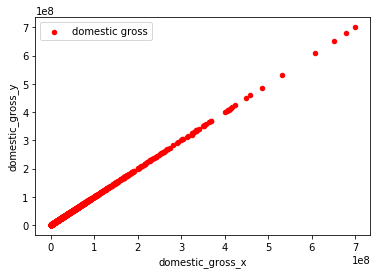

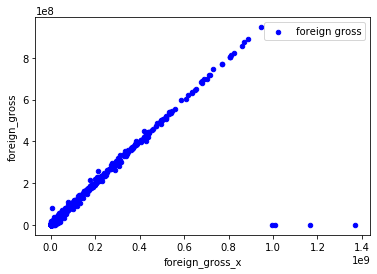

In [3]:
# load data 
file = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/bom.movie_gross.csv.gz'
bom = pd.read_csv(file)
# change column name so we can merge using 'title'
hf.rename_columns(budget, {'movie': 'title'})
# create a year column for budget because same title can be released during different years 
budget['year'] = budget.release_date.dt.year
# merge the two table using both title and year 
budget_bom = hf.merge_tables(budget, bom, ['title','year'], 'inner')
# convert foreign_gross as a float to perform scatter plot 
hf.stringtonum(budget_bom, ['foreign_gross'], ',')
# create foreign_gross_x to compare with each other 
budget_bom['foreign_gross_x'] = budget_bom['worldwide_gross'] - budget_bom['domestic_gross_x']
# check for if the revenue match from both table
budget_bom.plot(kind="scatter", x="domestic_gross_x",y="domestic_gross_y", color="r", label="domestic gross")
budget_bom.plot(kind = 'scatter', x="foreign_gross_x",y="foreign_gross", color="b", label="foreign gross")
plt.show()
# we confirmed budget dataset using bom 

# import and prepare tmdb.movies.csv
# extract genres vs popularity insights 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/anaconda3/lib/python3.7/sit

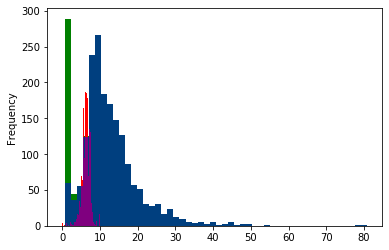

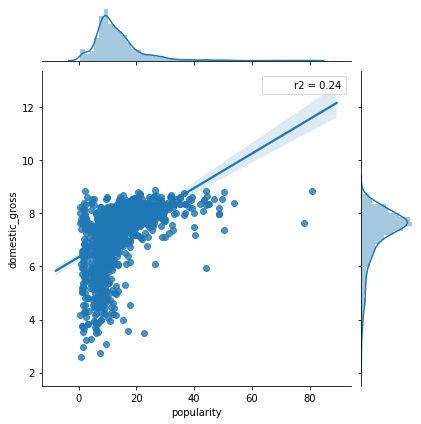

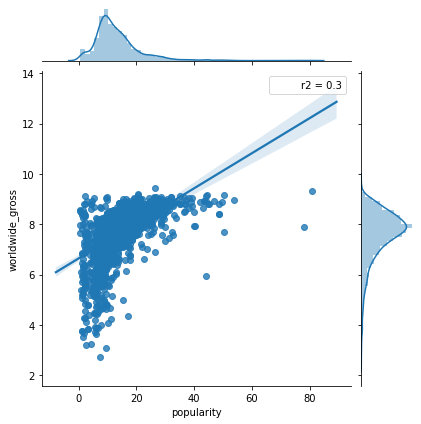

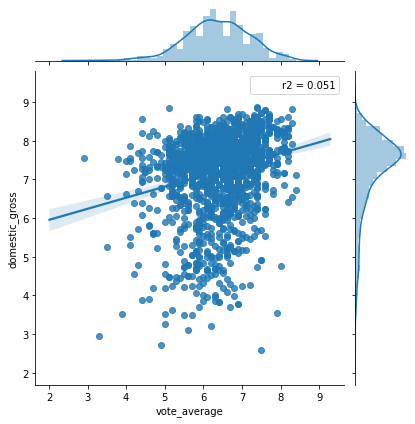

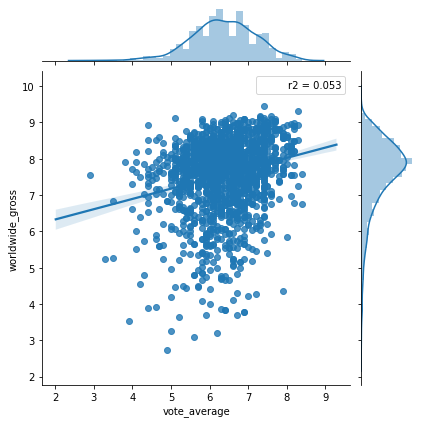

In [5]:
# import file as pandas dataframe
file_path = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/tmdb.movies.csv.gz'
tmdb = pd.read_csv(file_path, index_col=0, parse_dates=['release_date'])
# choose only english as langauge
mask = hf.create_masks(tmdb, ['original_language'], ['en'], [np.equal])
tmdb = tmdb[mask[0]]
# rename column 'title' with 'original_title' for merging
hf.rename_columns(budget, {'title': 'original_title'})
# merge with budget using original_title
merged_df = hf.merge_tables(budget, tmdb, 'original_title', how='inner')
# explore distribution of popularity
# notice spikes near zero, need to investigate
merged_df.popularity.plot.hist(bins=50, color='green')
# explore vote_average distribution
# appear to be almost normal distribution
merged_df.vote_average.plot.hist(bins=50, color='red')
# to fix popularity, we will remove vote_count under 10 to prevent bias
merged_df = merged_df[~(merged_df.vote_count < 10)]
# replot
merged_df.popularity.plot.hist(
    bins=50, color='blue', alpha=0.5)  # appear to be better
# plot scatter and find r2 for popularity versus domestic_gross columns
# before plot, we want to convert the scale into log10 and need to remove 0s
merged_df = merged_df[~(merged_df.domestic_gross == 0)]
merged_df = merged_df[~(merged_df.worldwide_gross == 0)]
sns.jointplot(merged_df['popularity'], np.log10(
    merged_df['domestic_gross']), kind="reg", stat_func=hf.r2)
sns.jointplot(merged_df['popularity'], np.log10(
    merged_df['worldwide_gross']), kind="reg", stat_func=hf.r2)
sns.jointplot(merged_df['vote_average'], np.log10(
    merged_df['domestic_gross']), kind="reg", stat_func=hf.r2)
sns.jointplot(merged_df['vote_average'], np.log10(
    merged_df['worldwide_gross']), kind="reg", stat_func=hf.r2)
# popularity is R2 is 0.3 while vote_average is 0.051, we will use popularity as a metric to estimate gross income
# we will use popularity to estimate how well genres perform using tmdb data frame 
# we obtained genre_map from Nick (he webscraped for us)
genre_map = {"genres": [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, 
                        {"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, 
                        {"id": 80, "name": "Crime"}, {"id": 99, "name": "Documentary"}, 
                        {"id": 18, "name": "Drama"}, {"id": 10751, "name": "Family"}, 
                        {"id": 14, "name": "Fantasy"}, 
                        {"id": 36, "name": "History"}, {"id": 27, "name": "Horror"},
                        {"id": 10402, "name": "Music"}, {"id": 9648, "name": "Mystery"}, 
                        {"id": 10749, "name": "Romance"}, {"id": 878, "name": "Science Fiction"}, 
                        {"id": 10770, "name": "TV Movie"}, {"id": 53, "name": "Thriller"}, 
                        {"id": 10752, "name": "War"}, {"id": 37, "name": "Western"}]}
# we will make the genre_map into a dictionary of id as key and genre is value
genre_dict = {}
for genre in genre_map['genres']:
    genre_dict[genre['id']] = genre['name']
# before we convert the genre id into genres we need to remove []    
table = str.maketrans(dict.fromkeys('[]'))  # a table map so translate will remove it 
tmdb.genre_ids = tmdb.genre_ids.dropna().apply(lambda x: x.translate(table))
# split genreids into separate rows 
genres_table = hf.split_rows(tmdb, 'id','genre_ids', ',')
# map genreid into genres 
genres_table.genre_ids = genres_table.genre_ids.str.strip()  # remove front and back empty space
genres_table = genres_table[~(genres_table.genre_ids == '')] #remove empty list 
genres_table.genre_ids = genres_table.genre_ids.astype(int)
genres_column = genres_table.set_index('id').applymap(lambda x: genre_dict.get(x, np.nan))
# combine genres with popularity so we can perform study 
genre_popularity = tmdb.merge(genres_column.reset_index(), on = 'id', how = 'inner')
# save genre_popularity table as pkl file for genre processing 
genre_popularity.to_pickle('genre_popularity.pkl')

# import, prepare and combine imdb dataframes  

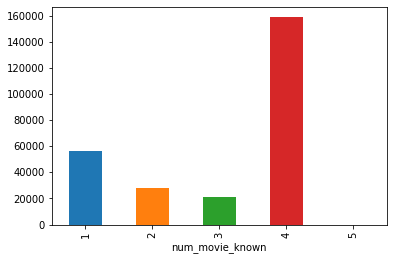

In [6]:
# load dataframe imdb.name.basics.csv
file_name = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/imdb.name.basics.csv.gz'
name = pd.read_csv(file_name)
# both birth and death have a lot of null value however we care about if the movie featured a hollywood star 
# we will remove both birth and death year
hf.drop_columns(name, 'birth_year','death_year')
# if known_for_titles are nan most likely not a star or known actor/actress
hf.drop_NA(name, ['known_for_titles'])
# turn name into dictionary # use this for title_crew_csv later (map director/writer id to names) 
name_dict_imdb = {}
for _, row in name.iterrows():
    name_dict_imdb[row['nconst']] = row['primary_name']
# filter actor and actress in primary_profession (that will be our focus )
name = name[name.primary_profession.str.contains('actor|actress', regex = True, na = False)]
# drop primary profession to reduce data size 
hf.drop_columns(name, 'primary_profession')
# create number of known for title as a column num_movie_known for filter known performers 
name['num_movie_known'] = name.known_for_titles.str.split(',').apply(lambda x: len(x))
# check for cutoff points 
name.groupby('num_movie_known').size().plot.bar()  # set 4 or more known movie as stars 
# we will check to see a few popular hollywood star
stars = ['Tom Cruise', 'Brad Pitt', 'Jennifer lawrence', 'Meryl Streep', \
         'Leonardo DiCaprio']
name[name.primary_name.isin(stars)]  # confirm that 4 star is a good place to cut for stars 
# keep only num_movie_known is 4 or higher 
masks = hf.create_masks(name, ['num_movie_known'],[4],relations = [np.greater_equal])
name = name[masks[0]]
# remove known for title and num_movie known as we only need nconst and primary name
hf.drop_columns(name, 'known_for_titles','num_movie_known')
# load data: imdb.title.principals.csv
file_crew = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/imdb.title.principals.csv.gz'
title_crew = pd.read_csv(file_crew)
# remove characters, job, ordering is for repeating movie id with crew info 
hf.drop_columns(title_crew, 'characters','job','ordering')
# only interested in actor, actress 
title_crew = title_crew[title_crew.category.isin(['actor','actress'])]
# merge the title_crew with name crew with nconst 
imdb_merge =hf.merge_tables(title_crew, name, 'nconst','inner')
# remove nconst as no longer useful
hf.drop_columns(imdb_merge, 'nconst')
# create new column called num_known_actor_actress
imdb_merge['num_known_actor_actress']= hf.object_binary(imdb_merge, 'category', 'actor', 'actress')
# load data: imdb.title.principals.csv
file_crew = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/imdb.title.principals.csv.gz'
title_crew = pd.read_csv(file_crew)
# remove characters, job, ordering is for repeating movie id with crew info 
hf.drop_columns(title_crew, 'characters','job','ordering')
# only interested in actor, actress 
title_crew = title_crew[title_crew.category.isin(['actor','actress'])]
# merge the title_crew with name crew with nconst 
imdb_merge =hf.merge_tables(title_crew, name, 'nconst','inner')
# remove nconst as no longer useful
hf.drop_columns(imdb_merge, 'nconst')
# create new column called num_known_actor_actress
imdb_merge['num_known_actor_actress']= hf.object_binary(imdb_merge, 'category', 'actor', 'actress')

# create total number of known actor actress by movie 
imdb_merge = imdb_merge.groupby('tconst').sum()  # group by movies 
imdb_merge = imdb_merge.reset_index()
# load imdb.title.basics.csv for titles
file_basics = 'https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/imdb.title.basics.csv.gz'
title_basics = pd.read_csv(file_basics)
# remove null values for genres and runtime_mins 
hf.drop_NA(title_basics, ['genres','runtime_minutes'])
# merge title_basics with imdb_merge for titles 
imdb_merge = hf.merge_tables(imdb_merge, title_basics, 'tconst', 'inner')
# save imdb_merge as pickle for merging with tmdb later 
imdb_merge.to_pickle('imdb_merge_1.pkl')
# work on directors and writers for finding the top 5 most popular director and writers 
# load imdb.title.crew.csv
file_director_writer ='https://raw.githubusercontent.com/learn-co-students/dc_ds_06_03_19/master/module_1/week_3_project/data/imdb.title.crew.csv.gz'
writers_directors = pd.read_csv(file_director_writer)
# create directors and writers separately to prevent repeat rows 
directors = writers_directors[['tconst','directors']].dropna()
directors = hf.split_rows(directors,'tconst','directors',',')
# map director number to name 
directors = directors.set_index('tconst').applymap(lambda x: name_dict_imdb.get(x, np.nan))

# create directors and writers separately to prevent repeat rows 
writers = writers_directors[['tconst','writers']].dropna()
writers = hf.split_rows(writers,'tconst','writers',',')
# map writer number to name 
writers = writers.set_index('tconst').applymap(lambda x: name_dict_imdb.get(x, np.nan))
# create writers_title
# create directors_title
writers_title = writers.merge(imdb_merge, on = 'tconst', how = 'inner')
directors_title = directors.merge(imdb_merge, on = 'tconst', how = 'inner')
# save these data frame to find top 5 most desirable writers/directors
writers_title.to_pickle('writers_title.pkl')
directors_title.to_pickle('directors_title.pkl')

# plot important visuals 

## use genre popularity to find relationships 

### genre alone has very similar popularity distribution
### genre vs month popularity median 

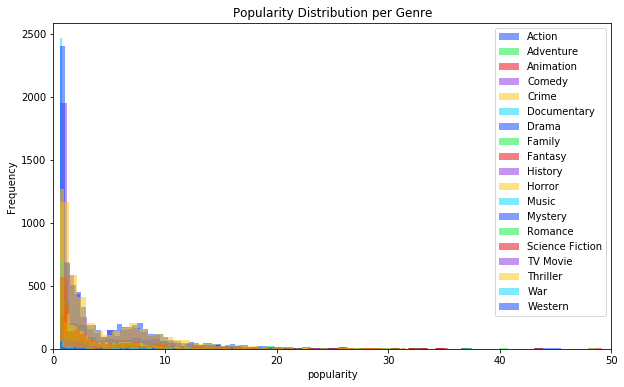

In [7]:
# we will only look at the last 10 years (before 2009 1-1)
genre_popularity = genre_popularity[genre_popularity.release_date > '2009-6-17']
# obtain month from release_date column
genre_popularity['month'] = genre_popularity.release_date.dt.month
# clean up the data frame a bit before further use
genre_popularity = genre_popularity[['popularity','month','genre_ids_y']]
hf.rename_columns(genre_popularity, {'genre_ids_y': 'genres'})
# look at popularity by genre distribtion 
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(figsize=(10,6))
genre_popularity.groupby('genres').popularity.plot(kind='hist', ax=ax, alpha = 0.5, bins = 100)
plt.title('Popularity Distribution per Genre')
plt.xlabel('popularity')
plt.xlim([0,50])
plt.legend()
plt.show()  
# appear to have the same popularity distribution 

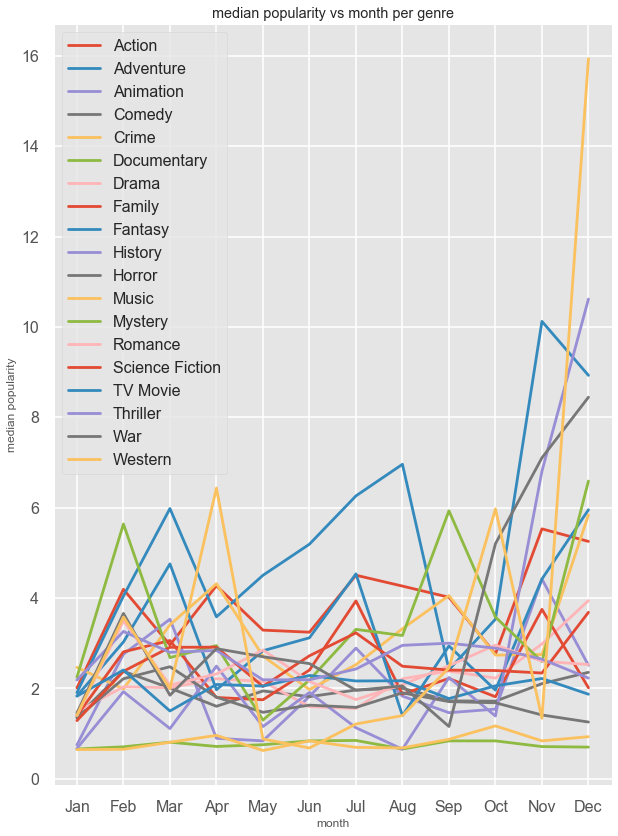

In [32]:
# distribution of genres appear to be skewed so we will use median not mean 
# create groupby dataframe 
genre_popularity_month = genre_popularity.groupby(['genres','month'])['popularity'].median().reset_index()
# use pivot to make into a long format 
genre_popularity_month = genre_popularity_month.pivot(index = 'month', columns = 'genres', values = 'popularity')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,14))
genre_popularity_month.plot( ax=ax)
plt.title('median popularity vs month per genre')
plt.xlabel('month')
plt.xticks(list(range(1,13)), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlim([0.5,12.5])
plt.ylabel('median popularity')
plt.legend(loc = 'upper left')
plt.show()  
# except for western the genres appear to be doing the same throughout the months 

# Top 5 writers and directors for best average popularity 

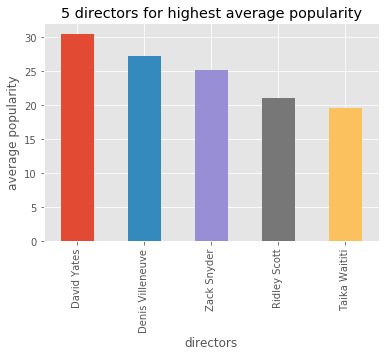

In [9]:
# keep vote count above 10 for tmdb to prevent low voting count affect regularization 
tmdb = tmdb[tmdb.vote_count>=10]
# top 5 directors 
merged_directors_tmdb = hf.merge_tables(tmdb, directors_title, 'original_title', 'inner')
# check for how many times each directors direct movies to remove low counts 
directors_count = merged_directors_tmdb.groupby('directors').size().sort_values(ascending = False).reset_index()
# change 0 to proper column name 
hf.rename_columns(directors_count, {0: 'movie_count'})
# merge with merged_directors_tmdb
merged_directors_count =hf.merge_tables(directors_count, merged_directors_tmdb, 'directors', 'inner')
# clean up the table 
merged_directors_count = merged_directors_count[['directors','popularity','movie_count','start_year']]
# filter for after 2009 and direct count above 3 movies 
merged_directors_count[(merged_directors_count['movie_count'] > 5) & (merged_directors_count.start_year >= 2009)].groupby(
    'directors')['popularity'].mean().sort_values(ascending=False)[:5].plot.bar()
plt.ylabel('average popularity')
plt.title('5 directors for highest average popularity')
plt.show()

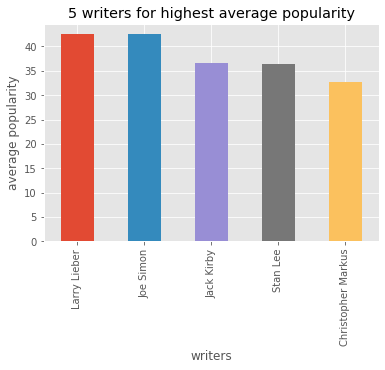

In [10]:
# top 5 writers 
merged_writers_tmdb = hf.merge_tables(tmdb, writers_title, 'original_title', 'inner')
# check for how many times each directors direct movies to remove low counts 
writers_count = merged_writers_tmdb.groupby('writers').size().sort_values(ascending = False).reset_index()
# change 0 to proper column name 
hf.rename_columns(writers_count, {0: 'movie_count'})
# merge with merged_directors_tmdb
merged_writers_count =hf.merge_tables(writers_count, merged_writers_tmdb, 'writers', 'inner')
# clean up the table 
merged_writers_count = merged_writers_count[['writers','popularity','movie_count','start_year']]
# filter for after 2009 and direct count above 3 movies 
merged_writers_count[(merged_writers_count['movie_count'] > 5) & (merged_directors_count.start_year >= 2009)].groupby(
    'writers')['popularity'].mean().sort_values(ascending=False)[:5].plot.bar()
plt.ylabel('average popularity')
plt.title('5 writers for highest average popularity')
plt.show()

# Hire known or unknown actor or actress

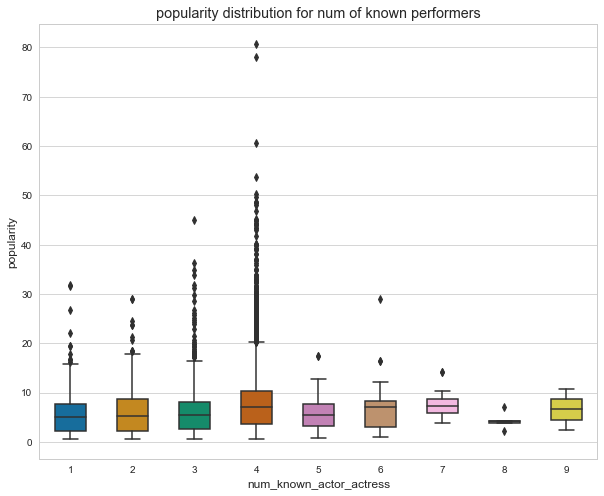

In [11]:
# need to merge with imdb to get popularity 
performer_popularity = hf.merge_tables(imdb_merge, tmdb, 'original_title', 'inner')
# only choose relevant columns, runtime for last analysis 
performer_popularity = performer_popularity[['num_known_actor_actress', 'runtime_minutes','popularity']]
# plot group by num_known_actor_actress
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
bplot = sns.boxplot(y='popularity', x='num_known_actor_actress', 
                 data=performer_popularity, 
                 width=0.5,
                 palette="colorblind")
plt.title('popularity distribution for num of known performers')
plt.show()

# What movie length to focus on 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


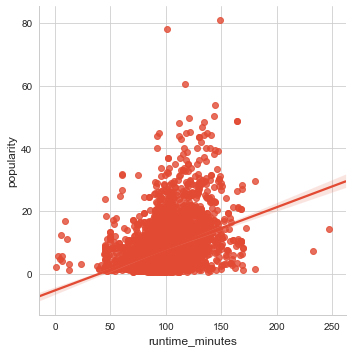

In [12]:
sns.set_style('whitegrid')
sns.lmplot(y = 'popularity', x = 'runtime_minutes', data  = performer_popularity)